In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from scipy import sparse

In [3]:
def load_data():
    netflix_csv_file = open("netflix_rating.csv", mode = "w")
    with open('../dataset/recommendation/combined_data_4.txt') as f:
        for line in f:
            line = line.strip()
            if line.endswith(":"):
                movie_id = line.replace(":", "")
            else:
                row_data = []
                row_data = [item for item in line.split(",")]
                row_data.insert(0, movie_id)
                netflix_csv_file.write(",".join(row_data))
                netflix_csv_file.write('\n')

    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])

    return df

In [4]:
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,13368,2385003,4,2004-07-08
1,13368,659432,3,2005-03-16
2,13368,751812,2,2002-12-16
3,13368,2625420,2,2004-05-25
4,13368,1650301,1,2005-08-30


In [5]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [6]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

C:\Users\sigma\AppData\Local\Temp\ipykernel_9288\1206673435.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


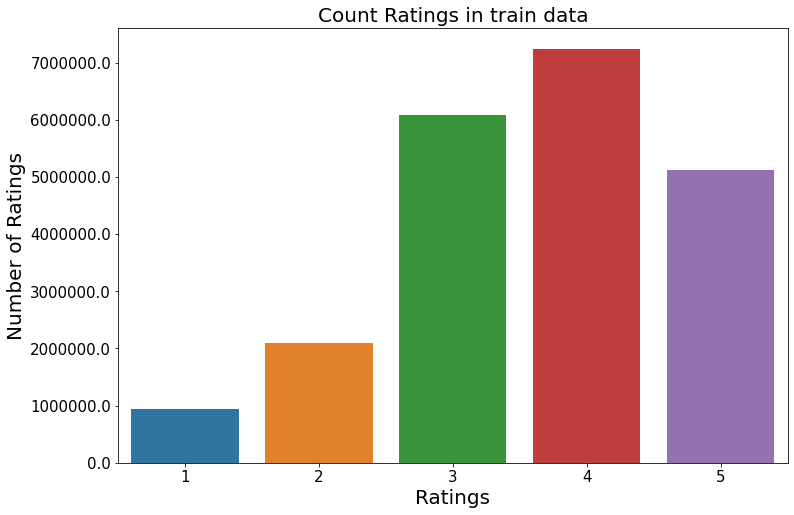

In [12]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [16]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [18]:
train_sparse_data = get_user_item_sparse_matrix(train_data)
test_sparse_data = get_user_item_sparse_matrix(test_data)
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print(f"Global Average Rating: {global_average_rating}")

Global Average Rating: 3.6291294662291467
